In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [18]:
df = pd.read_excel('XRays.xlsx')
df.head()

,stMRN,dtArrive,dtBegin,dtCompleted
0,12222732,2016-04-04 08:00:21,2016-04-04 08:04:56,2016-04-04 08:11:52
1,13510077,2016-04-04 08:21:54,2016-04-04 08:26:40,2016-04-04 08:39:12
2,11183882,2016-04-04 08:33:38,2016-04-04 08:44:53,2016-04-04 08:44:58
3,12949996,2016-04-04 08:38:16,2016-04-04 08:41:27,2016-04-04 08:47:34
4,11566221,2016-04-04 08:26:10,2016-04-04 08:33:21,2016-04-04 08:53:06


In [19]:
print(df.dtypes)


stMRN                   int64
dtArrive       datetime64[ns]
dtBegin        datetime64[ns]
dtCompleted    datetime64[ns]
dtype: object


#Task 6

In [20]:
# Using a dictionary to store the number of patients for each minute
time_usage = defaultdict(int)

# For each exam, increase the counter for every minute from the start to the end of the exam
for index, row in df.iterrows():
    start = row['dtBegin']
    end = row['dtCompleted']

    # Increase the counter for each minute in the interval (excluding the final minute)
    for minute in pd.date_range(start=start, end=end - pd.Timedelta(minutes=1), freq='min'):
        time_usage[minute] += 1

# Find the maximum number of patients who were simultaneously undergoing an examination
max_rooms = max(time_usage.values())

print(f"Maximum number of X-ray rooms in use in the facility: {max_rooms}")


Maximum number of X-ray rooms in use in the facility: 4


In [21]:
# Create a list of events for each exam start and end
events = []

for index, row in df.iterrows():
    events.append((row['dtBegin'], 'start'))
    events.append((row['dtCompleted'], 'end'))

# Sort events by time, giving priority to 'end' over 'start' if times are equal
events.sort(key=lambda x: (x[0], x[1] == 'start'))

# Track the number of rooms in use
current_rooms = 0
max_rooms = 0

for event in events:
    if event[1] == 'start':
        current_rooms += 1
    elif event[1] == 'end':
        current_rooms -= 1
    max_rooms = max(max_rooms, current_rooms)

print(f"Maximum number of X-ray rooms in use in the facility: {max_rooms}")

Maximum number of X-ray rooms in use in the facility: 21


In [22]:
# Sort data by patient and start time
df= df.sort_values(by=['stMRN', 'dtBegin'])

# Retain only one record per patient who continuously occupied the room
filtered_data = []
for patient_id, group in df.groupby('stMRN'):
    continuous = group.iloc[0].copy()  # Start with the first record
    for i in range(1, len(group)):
        if group.iloc[i]['dtBegin'] <= continuous['dtCompleted']:
            continuous['dtCompleted'] = max(continuous['dtCompleted'], group.iloc[i]['dtCompleted'])
        else:
            filtered_data.append(continuous)
            continuous = group.iloc[i].copy()  # Move to the next record if there is a gap
    filtered_data.append(continuous)  # Add the last continuous record

# Create a DataFrame from the filtered records
filtered_df = pd.DataFrame(filtered_data)

# Get unique days from the original data
unique_dates = df['dtArrive'].dt.date.unique()

max_rooms_overall = []

for date in unique_dates:
    # Create a time range for each day from 07:00 to 20:00 with 30-minute intervals
    time_range = pd.date_range(f"{date} 07:00:00", f"{date} 20:00:00", freq='30min')

    # Calculate the number of ongoing exams for the original data
    rooms_in_use = []
    for time_point in time_range:
        ongoing_exams = df[(df['dtBegin'] <= time_point) &
                                   (df['dtCompleted'] >= time_point)]
        rooms_in_use.append(len(ongoing_exams))

    max_rooms_before_filtering = max(rooms_in_use)
    max_rooms_overall.append((date, max_rooms_before_filtering))

    # Calculate the number of ongoing exams for the filtered data
    rooms_in_use_filtered = []
    for time_point in time_range:
        ongoing_exams_filtered = filtered_df[(filtered_df['dtBegin'] <= time_point) &
                                             (filtered_df['dtCompleted'] >= time_point)]
        rooms_in_use_filtered.append(len(ongoing_exams_filtered))

    max_rooms_after_filtering = max(rooms_in_use_filtered)

    # Store the result based on the index of the maximum before filtering
    max_rooms_overall[-1] += (max_rooms_after_filtering,)

# Calculate the overall maximum number of rooms before filtering
overall_max_before = max([before for _, before, _ in max_rooms_overall])

# Output the results
for date, before, after in max_rooms_overall:
    if before == overall_max_before:
        print(f"Date: {date}, Maximum rooms before filtering: {before}, Maximum rooms after filtering: {after}")

Date: 2016-11-08, Maximum rooms before filtering: 17, Maximum rooms after filtering: 8


# Task 7

In [23]:
events = []

for index, row in df.iterrows():
    events.append((row['dtArrive'], 'arrive'))
    events.append((row['dtBegin'], 'begin'))

# Sort events by time, with arrival having priority if times are equal
events.sort(key=lambda x: (x[0], x[1] == 'begin'))

# Count the number of patients in the waiting area at each moment and find the maximum
current_waiting = 0
max_waiting = 0

for event in events:
    if event[1] == 'arrive':
        current_waiting += 1
    elif event[1] == 'begin':
        current_waiting -= 1
    max_waiting = max(max_waiting, current_waiting)

print(f"Maximum number of patients in the waiting area: {max_waiting}")


Maximum number of patients in the waiting area: 37


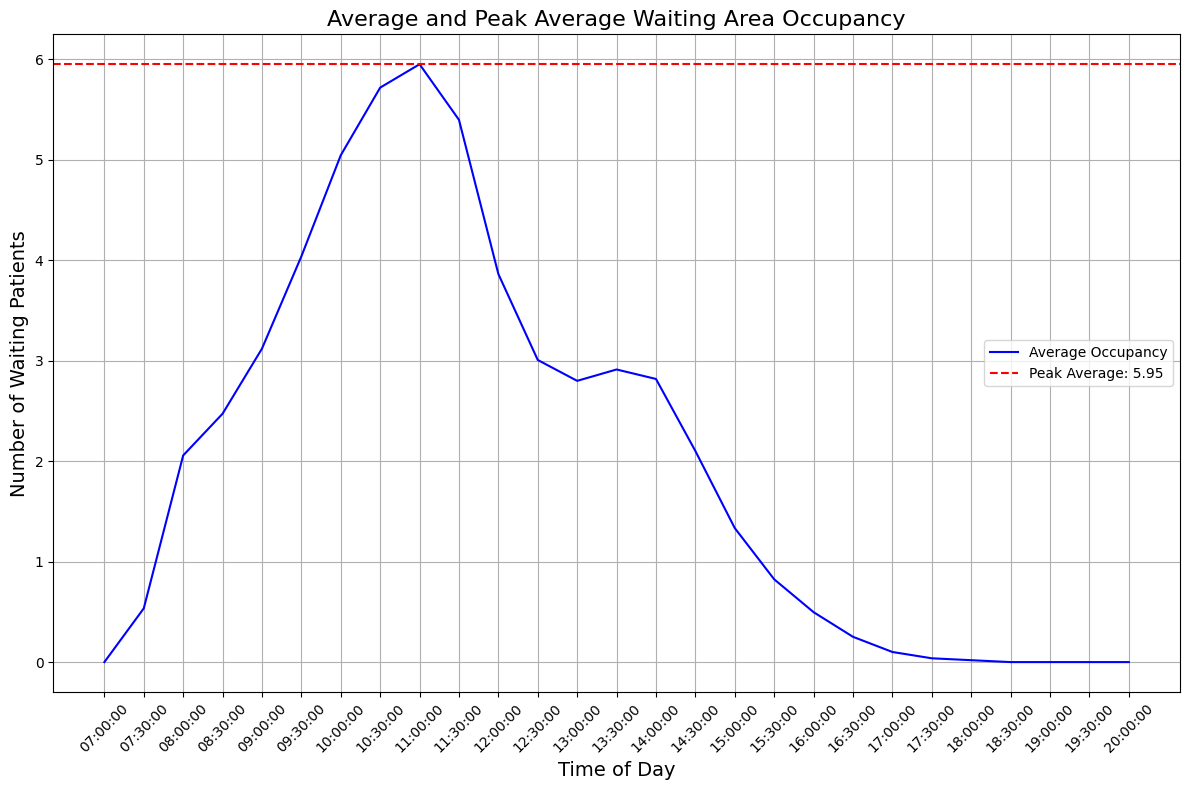

The peak average waiting area occupancy is approximately 5.95 patients.


In [24]:
df['Date'] = df['dtArrive'].dt.date  # Extract date from arrival time

# Define time sampling array (from 7 AM to 8 PM, every 30 minutes)
time_samples = pd.date_range("07:00", "20:00", freq="30min").time

# Function to calculate waiting patients for each day
def calculate_waiting_patients_per_day(data):
    waiting_counts = []
    for time in time_samples:
        count = len(data[(data['dtArrive'].dt.time <= time) & (data['dtBegin'].dt.time > time)])
        waiting_counts.append(count)
    return waiting_counts

# Calculate waiting patients per day and combine results
daily_waiting_data = {day: calculate_waiting_patients_per_day(group) for day, group in df.groupby('Date')}
combined_data = pd.DataFrame({
    'Time': time_samples,
    'Waiting Patients': [sum(data) for data in zip(*daily_waiting_data.values())]
})

# Calculate average waiting area occupancy
combined_data['Waiting Patients'] /= len(daily_waiting_data)

# Find peak average waiting area occupancy
peak_average_waiting_patients = combined_data['Waiting Patients'].max()

# Convert Time to string format for plotting
combined_data['Time'] = combined_data['Time'].astype(str)

# Plotting the average waiting area occupancy and peak average
plt.figure(figsize=(12, 8))
plt.plot(combined_data['Time'], combined_data['Waiting Patients'], label='Average Occupancy', linestyle='-', color='b')
plt.axhline(y=peak_average_waiting_patients, color='r', linestyle='--', label=f'Peak Average: {peak_average_waiting_patients:.2f}')

# Graph settings
plt.title('Average and Peak Average Waiting Area Occupancy', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Number of Waiting Patients', fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Text output for peak average waiting area occupancy
print(f"The peak average waiting area occupancy is approximately {peak_average_waiting_patients:.2f} patients.")


#Task *8*

In [25]:
# Create a column to round the start time of the examination to the desired interval (e.g., each hour)
df['interval'] = df['dtBegin'].dt.floor('h')  # Rounding to the nearest hour

# Count the number of examinations in each interval
interval_counts = df['interval'].value_counts().sort_index()

# Find the interval with the maximum number of examinations
peak_interval = interval_counts.idxmax()
peak_count = interval_counts.max()

print(f"Time interval with the maximum load: {peak_interval} - {peak_interval + pd.Timedelta(hours=1)}")
print(f"Number of X-ray examinations in this interval: {peak_count}")


Time interval with the maximum load: 2016-09-15 10:00:00 - 2016-09-15 11:00:00
Number of X-ray examinations in this interval: 46


In [26]:
# Create a column with the date to group by date and time later
df['date'] = df['dtBegin'].dt.date

# Define a function that checks which of the given intervals the time belongs to
def get_time_interval(dt):
    time = dt.time()
    if time >= pd.Timestamp("07:00:00").time() and time < pd.Timestamp("09:00:00").time():
        return "7:00-9:00"
    elif time >= pd.Timestamp("10:00:00").time() and time < pd.Timestamp("12:00:00").time():
        return "10:00-12:00"
    elif time >= pd.Timestamp("13:00:00").time() and time < pd.Timestamp("15:00:00").time():
        return "13:00-15:00"
    elif time >= pd.Timestamp("14:00:00").time() and time < pd.Timestamp("16:00:00").time():
        return "14:00-16:00"
    else:
        return None

# Apply the function to determine the time interval for each examination start time
df['time_interval'] = df['dtBegin'].apply(get_time_interval)

# Filter only those records that fall within the specified intervals
df_filtered = df[df['time_interval'].notna()]

# Count the number of examinations for each interval by each date
interval_counts = df_filtered.groupby(['date', 'time_interval']).size().reset_index(name='count')

# Find the average number of examinations for each time interval
average_counts = interval_counts.groupby('time_interval')['count'].mean().reset_index()

print(average_counts)


  time_interval      count
0   10:00-12:00  43.740506
1   13:00-15:00  29.759494
2   14:00-16:00   7.778481
3     7:00-9:00  19.841772
